### ✉️ Spam Detection with LSTM Neural Network

This project focuses on building a binary text classification model that distinguishes between spam and ham (non-spam) emails. Using deep learning techniques, specifically an LSTM (Long Short-Term Memory) neural network, the model learns to identify patterns in email content and predict whether a message is unsolicited (spam) or legitimate (ham).

📚 Inspiration & Dataset

The initial idea and dataset were inspired by an article available on  [GeeksforGeeks](https://www.geeksforgeeks.org/detecting-spam-emails-using-tensorflow-in-python/), which served as a helpful starting point for understanding the fundamentals of spam detection using deep learning.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [12]:
data = pd.read_csv('spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


### Handling Imbalanced Data

During exploration, it becomes clear that the dataset suffers from significant class imbalance — the number of ham messages heavily outweighs the number of spam ones. Training a model on such skewed data can lead to biased predictions, where the model favors the majority class and fails to learn meaningful patterns for the minority class.

In [13]:
data.shape

(5171, 4)

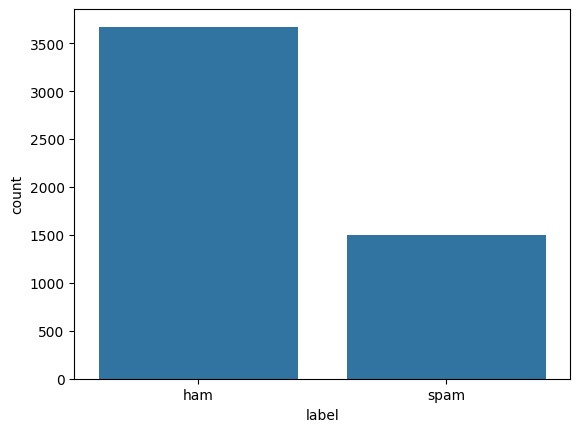

In [14]:
sns.countplot(x='label', data=data)
plt.show()

To address the problem with the imbalance classes, undersampling is applied: the majority class (ham) is randomly reduced in size to match the number of spam examples. This ensures a balanced dataset and gives the model equal exposure to both classes, which is crucial for learning to distinguish spam effectively.

Balancing the data this way improves both precision and recall for the minority class.

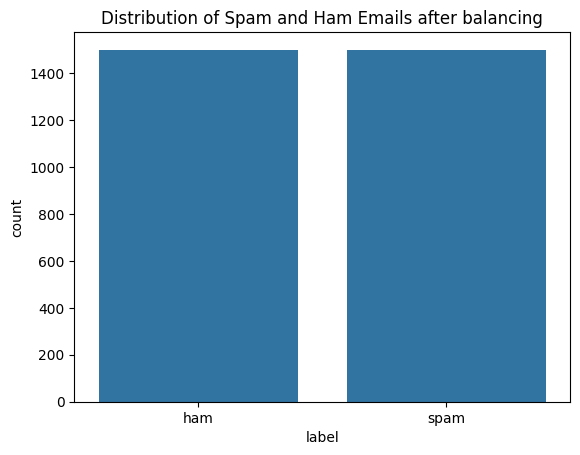

In [15]:
hamMails = data[data['label'] == 'ham']
spamMails = data[data['label'] == 'spam']

hamMailsBalanced = hamMails.sample(n=len(spamMails), random_state=42)

balanced_data = pd.concat([hamMailsBalanced, spamMails]).reset_index(drop=True)

sns.countplot(x='label', data=balanced_data)
plt.title("Distribution of Spam and Ham Emails after balancing")
plt.show()

### Data Cleaning

Before feeding data into the model, we apply several preprocessing steps to clean and standardize the data. This process helps reduce noise and improve the model's ability to learn meaningful patterns from the text.

Cleaning pipeline includes:

* Removal of the word "Subject" from the beginning of emails, which does not carry useful information for classification.

* Punctuation removal to simplify the text and reduce variability.

* Lowercasing all words to ensure consistency (e.g., "Free" and "free" are treated the same).

* Stopword removal to eliminate common words (like "the", "is", "and") that do not contribute significantly to spam detection.

By applying these transformations, the text becomes cleaner, more uniform, and more focused on informative content that actually influences classification decisions.

In [16]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '', regex=False)

In [17]:
def remove_punctuations(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

balanced_data['text'] = balanced_data['text'].apply(remove_punctuations)

In [18]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(words)

balanced_data['text'] = balanced_data['text'].apply(remove_stopwords)
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,conoco big cowboy darren sure help know else a...,0
1,2982,ham,feb 01 prod sale teco gas processing sale deal...,0
2,2711,ham,california energy crisis california  power cr...,0
3,3116,ham,nom actual volume april 23 rd agree eileen pon...,0
4,1314,ham,eastrans nomination changes effective 8 2 00 p...,0


### Data Preparation

The raw email messages are still in textual form, so several preprocessing steps are necessary to convert them into a format suitable for training:

1. **Train-test split**:
  The balanced dataset is split into training and testing sets using an 80-20 ratio.

2. **Tokenization:**
A `Tokenizer` is fitted on the training texts. This process builds a vocabulary based on the training data and assigns a unique integer to each word. Tokenization is crucial for converting text into a numerical format that neural networks can process.

3. **Sequence conversion:**
Both training and testing texts are transformed into sequences of integers. Each email becomes a list of word indices, preserving word order — a critical factor for LSTM models which capture sequential dependencies.

4. **Padding and truncating:**
To ensure all sequences are of equal length, they are padded (or truncated) to a maximum length of 100 tokens. Padding is applied post-sequence, meaning that shorter sequences are extended by zeros at the end. This uniformity is required for batch processing in neural networks.

In [19]:
train_X, test_X, train_Y, test_Y = train_test_split(
    balanced_data['text'], balanced_data['label_num'], test_size=0.2, random_state=42
)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)

max_len = 100
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

### Model Architecture & Compilation

The model is built using the Keras Sequential API, with a focus on simplicity and effectiveness for binary text classification. The architecture starts with an **Embedding layer**, which transforms each word (represented as an integer) into a dense 32-dimensional vector. This allows the model to capture semantic relationships between words in a continuous vector space, which is essential for understanding textual patterns.

Next, an **LSTM (Long Short-Term Memory)** layer with 16 units is added to process sequences of word embeddings. LSTM is well-suited for this task because it can capture long-range dependencies and contextual information in the input text — a crucial factor for detecting whether a message is spam or ham.

Following the LSTM, a **Dense** layer with 32 neurons and ReLU activation is used to introduce non-linearity and learn higher-level features from the LSTM output. Finally, the output layer consists of a single neuron with a sigmoid activation function, which produces a probability score indicating the likelihood that the message is spam.

The model is compiled with the Adam optimizer, known for its adaptive learning rate and efficiency on sparse gradients. The binary crossentropy loss function is used since this is a two-class classification problem, and from_logits=False is specified because the final layer outputs a probability (not raw logits). The model tracks accuracy as the evaluation metric during training.


In [20]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(max_len,)),
    tf.keras.layers.Embedding(
        input_dim=len(tokenizer.word_index) + 1,
        output_dim=32
    ),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - accuracy: 0.5244 - loss: 0.6927 - val_accuracy: 0.5983 - val_loss: 0.6823
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.7808 - loss: 0.5232 - val_accuracy: 0.9517 - val_loss: 0.1832
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.9519 - loss: 0.1799 - val_accuracy: 0.9567 - val_loss: 0.1743
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9668 - loss: 0.1362 - val_accuracy: 0.9583 - val_loss: 0.1719
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9712 - loss: 0.1227 - val_accuracy: 0.9550 - val_loss: 0.1832
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.9749 - loss: 0.1095 - val_accuracy: 0.9533 - val_loss: 0.1949
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.9467 - loss: 0.1761 - val_accuracy: 0.8750 - val_loss: 0.3290
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.8801 - loss: 0.2859 - val_accuracy: 0.9200 - v

### Model Evaluation on Test Data

After training, the model is evaluated on a separate test dataset to assess its ability to generalize to unseen examples. This evaluation is performed using the model.evaluate() function, which returns the binary cross-entropy loss and the accuracy score on the test set. The test accuracy provides an unbiased measure of the model's performance in real-world scenarios where the data distribution matches the test samples.

In [22]:
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9744 - loss: 0.1412
Test Loss : 0.1451331377029419
Test Accuracy : 0.9733333587646484


### Training & Validation Accuracy
To gain further insight into the model’s learning process, the training and validation accuracy are tracked and visualized across all epochs. The following plot shows how both metrics evolve over time.

This visualization helps identify potential issues such as overfitting (when validation accuracy stagnates or decreases while training accuracy keeps improving) or underfitting (when both accuracies remain low). In this case, the plot indicates stable learning and provides confidence that the model is not overfitting the training data.

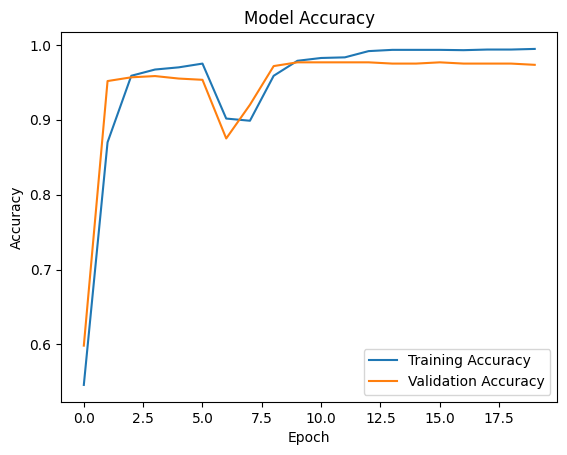

In [23]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Conclusion
The project successfully builds and trains a deep learning model to detect spam messages using an LSTM-based neural network. Starting from raw text data, the pipeline includes data cleaning, balancing the dataset, sequence modeling, and training with proper evaluation. The use of undersampling ensures fair learning, and the chosen model architecture strikes a good balance between complexity and performance.

Evaluation results and accuracy plots confirm that the model generalizes well and can be used as a reliable spam detection tool in practice. With further tuning or a larger, more diverse dataset, performance could be improved even more — but the current results already demonstrate the practical strength of deep learning in handling real-world NLP problems.